## Exploratory Data Analysis (EDA)

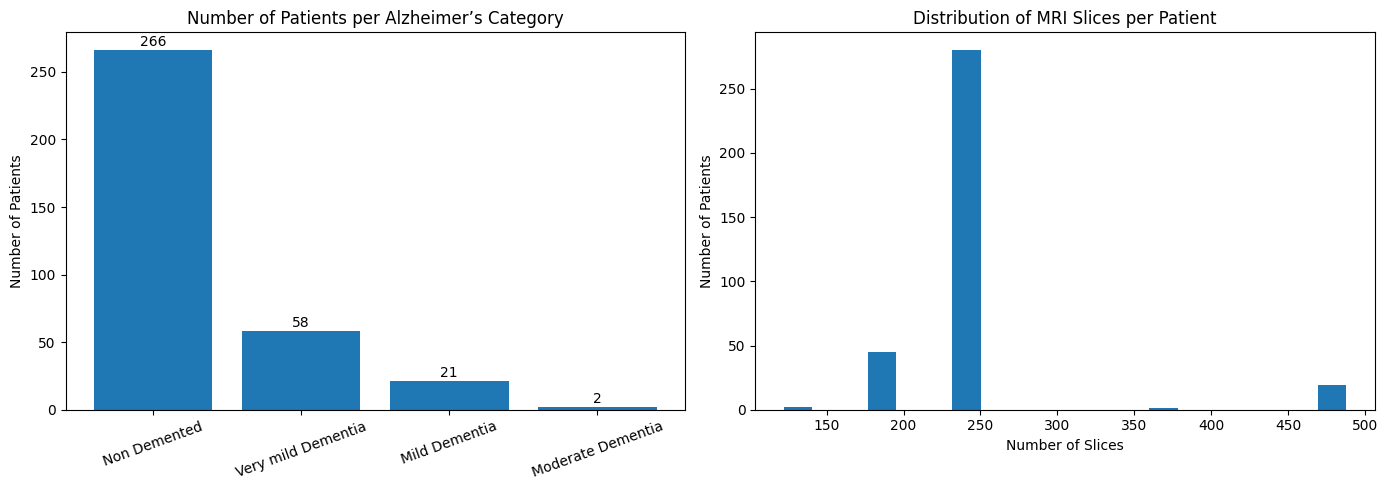

Patient count per class:
Non Demented: 266
Very mild Dementia: 58
Mild Dementia: 21
Moderate Dementia: 2

Slice statistics:
Min slices: 122
Max slices: 488
Mean slices: 249.10


In [ ]:
import os
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# 1. DATASET PATH & CLASSES
# ==============================
DATA_ROOT = "/kaggle/input/imagesoasis/Data"
CLASSES = [
    "Non Demented",
    "Very mild Dementia",
    "Mild Dementia",
    "Moderate Dementia"
]

# Regex to extract patient ID (e.g. OAS1_0028_ → 0028)
PATIENT_REGEX = re.compile(r"OAS1_(\d{4})_")

# ==============================
# 2. COUNT PATIENTS & SLICES
# ==============================
patients_per_class = defaultdict(set)
slices_per_patient = defaultdict(int)

for cls in CLASSES:
    class_dir = os.path.join(DATA_ROOT, cls)
    if not os.path.exists(class_dir):
        continue

    for root, _, files in os.walk(class_dir):
        for file in files:
            match = PATIENT_REGEX.search(file)
            if match:
                patient_id = match.group(1)
                patients_per_class[cls].add(patient_id)
                slices_per_patient[patient_id] += 1

# ==============================
# 3. PATIENT COUNT PER CLASS
# ==============================
class_names = []
patient_counts = []

for cls in CLASSES:
    class_names.append(cls)
    patient_counts.append(len(patients_per_class[cls]))

# ==============================
# 4. SLICES PER PATIENT
# ==============================
slice_counts = list(slices_per_patient.values())

# ==============================
# 5. PLOTTING
# ==============================
plt.figure(figsize=(14, 5))

# ---- Graph 1: Patients per Class ----
plt.subplot(1, 2, 1)
bars = plt.bar(class_names, patient_counts)
plt.title("Number of Patients per Alzheimer’s Category")
plt.ylabel("Number of Patients")
plt.xticks(rotation=20)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{int(height)}", ha="center", va="bottom")

# ---- Graph 2: Slice Distribution per Patient ----
plt.subplot(1, 2, 2)
plt.hist(slice_counts, bins=20)
plt.title("Distribution of MRI Slices per Patient")
plt.xlabel("Number of Slices")
plt.ylabel("Number of Patients")

plt.tight_layout()
plt.show()

# ==============================
# 6. PRINT SUMMARY (Optional)
# ==============================
print("Patient count per class:")
for cls in CLASSES:
    print(f"{cls}: {len(patients_per_class[cls])}")

print("\nSlice statistics:")
print(f"Min slices: {np.min(slice_counts)}")
print(f"Max slices: {np.max(slice_counts)}")
print(f"Mean slices: {np.mean(slice_counts):.2f}")


In [ ]:
import os
import json
import re
from collections import defaultdict

# ===============================
# CONFIG
# ===============================
DATA_ROOT = '/kaggle/input/imagesoasis/Data'
PATIENT_SPLIT_JSON = '/kaggle/input/patient-split-1/patient_split.json'

# Combine all dementia classes into one
CLASS_MAPPING = {
    'Non Demented': 0,
    'Very mild Dementia': 1,
    'Mild Dementia': 1,
    'Moderate Dementia': 1
}

# ===============================
# UTILITY FUNCTIONS
# ===============================
def extract_patient_id(filename):
    """Extract patient ID from filename like OAS1_0028_MR1_mpr-1_100.jpg"""
    match = re.search(r'OAS1_(\d+)_', filename)
    return int(match.group(1)) if match else None

# ===============================
# LOAD DATASET & MAP PATIENT TO CLASS
# ===============================
patient_to_class = dict()

for class_name, class_label in CLASS_MAPPING.items():
    class_dir = os.path.join(DATA_ROOT, class_name)
    if not os.path.exists(class_dir):
        continue

    for fname in os.listdir(class_dir):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        pid = extract_patient_id(fname)
        if pid is not None:
            patient_to_class[pid] = class_label

print(f"Total patients mapped: {len(patient_to_class)}")

# ===============================
# LOAD JSON SPLIT
# ===============================
with open(PATIENT_SPLIT_JSON, 'r') as f:
    split_data = json.load(f)

train_patients = split_data['train_patients']
val_patients = split_data['val_patients']
test_patients = split_data['test_patients']

# ===============================
# CROSS CHECK PATIENTS WITH CLASS
# ===============================
def get_patient_classes(patient_list, patient_to_class):
    """Return dictionary of patient ID -> class"""
    patient_class_dict = dict()
    for pid in patient_list:
        label = patient_to_class.get(pid, None)
        if label is not None:
            patient_class_dict[pid] = label
        else:
            print(f"⚠ Warning: Patient {pid} not found in dataset")
    return patient_class_dict

train_classes = get_patient_classes(train_patients, patient_to_class)
val_classes   = get_patient_classes(val_patients, patient_to_class)
test_classes  = get_patient_classes(test_patients, patient_to_class)

# ===============================
# SUMMARY
# ===============================
def summarize_classes(patient_class_dict):
    counts = defaultdict(int)
    for pid, label in patient_class_dict.items():
        counts[label] += 1
    return dict(counts)

print("\nTrain class distribution:", summarize_classes(train_classes))
print("Val class distribution:", summarize_classes(val_classes))
print("Test class distribution:", summarize_classes(test_classes))


Total patients mapped: 347

Train class distribution: {1: 50, 0: 158}
Val class distribution: {1: 14, 0: 55}
Test class distribution: {1: 17, 0: 53}


## Preprocessing

In [ ]:
import os
import re
import json
import numpy as np
from collections import defaultdict
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

# Scikit-learn imports
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# CONFIGURATION
# ============================================================================

# Dataset configuration
DATA_ROOT = '/kaggle/input/imagesoasis/Data'
PATIENT_SPLIT_JSON = '/kaggle/input/patient-split/patient_split.json'  # Path to your patient split JSON
CLASS_MAPPING = {
    'Non Demented': 0,
    'Very mild Dementia': 1,
    'Mild Dementia': 1,
    'Moderate Dementia': 1
}

# Preprocessing configuration
PREPROCESSING_REMOVE_DARK_SLICES = 20
PREPROCESSING_TARGET_DEPTH = 32
TARGET_SIZE = 256

# Training configuration
BATCH_SIZE = 4  # Smaller batch size due to larger input
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_PATIENCE = 10

# Random seed (should match patient.json)
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def extract_patient_id(filename):
    """Extract patient ID from OASIS-1 filename"""
    match = re.search(r'OAS1_(\d+)_', filename)
    return int(match.group(1)) if match else None

def extract_slice_number(filename):
    """Extract slice number from OASIS-1 filename"""
    match = re.search(r'_(\d+)\.(jpg|jpeg|png)$', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None

def load_patient_split(json_path):
    """Load patient split from JSON file"""
    with open(json_path, 'r') as f:
        split_data = json.load(f)
    return split_data

# ============================================================================
# DATA LOADING
# ============================================================================

def load_slices_by_patient(data_root, class_mapping):
    """
    Load all slices and organize by patient ID

    Returns:
        patient_slices: {patient_id: {'slices': [{'path': str, 'slice_num': int}],
                                      'label': int, 'class': str}}
    """
    patient_slices = defaultdict(lambda: {'slices': [], 'label': None, 'class': None})

    for class_name, class_label in class_mapping.items():
        class_dir = os.path.join(data_root, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found, skipping...")
            continue

        for filename in os.listdir(class_dir):
            if not filename.endswith(('.jpg', '.jpeg', '.png')):
                continue

            patient_id = extract_patient_id(filename)
            slice_num = extract_slice_number(filename)

            if patient_id is None or slice_num is None:
                continue

            img_path = os.path.join(class_dir, filename)
            patient_slices[patient_id]['slices'].append({
                'path': img_path,
                'slice_num': slice_num,
                'filename': filename
            })
            patient_slices[patient_id]['label'] = class_label
            patient_slices[patient_id]['class'] = class_name

    # Sort slices by slice number for each patient
    for patient_id in patient_slices:
        patient_slices[patient_id]['slices'].sort(key=lambda x: x['slice_num'])

    return dict(patient_slices)

# ============================================================================
# PIXEL VOLUME PROCESSING
# ============================================================================

def load_slice_as_pixel(img_path, target_size=256):
    """Load single slice as normalized pixel array"""
    img = Image.open(img_path).convert('L')  # Grayscale
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)

    # Convert to numpy array and normalize to [0, 1] min max scaling
    pixel_array = np.array(img, dtype=np.float32) / 255.0

    return pixel_array  # (256, 256)

def load_pixel_volume_from_patient(patient_data, target_size=256):
    """
    Load all slices as pixel volume

    Args:
        patient_data: {'slices': [{'path': str, 'slice_num': int}], 'label': int}
        target_size: Image size

    Returns:
        pixel_volume: np.array of shape (num_slices, target_size, target_size)
    """
    slices = patient_data['slices']
    pixel_slices = []

    for slice_info in slices:
        pixel_array = load_slice_as_pixel(slice_info['path'], target_size)
        pixel_slices.append(pixel_array)

    # Stack into 3D volume: (num_slices, H, W)
    pixel_volume = np.stack(pixel_slices, axis=0)

    return pixel_volume

def remove_dark_slices(pixel_volume, n_slices=20):
    """
    Remove n darkest slices from pixel volume

    Args:
        pixel_volume: (num_slices, H, W)
        n_slices: Number of dark slices to remove

    Returns:
        cleaned_volume: (num_slices - n, H, W)
    """
    num_slices = pixel_volume.shape[0]

    if num_slices <= n_slices:
        return pixel_volume

    # Calculate mean intensity per slice
    slice_intensities = []
    for i in range(num_slices):
        mean_intensity = np.mean(pixel_volume[i])
        slice_intensities.append((i, mean_intensity))

    # Sort by intensity and get indices to remove
    slice_intensities.sort(key=lambda x: x[1])
    slices_to_remove = {idx for idx, _ in slice_intensities[:n_slices]}

    # Keep valid slices
    valid_indices = [i for i in range(num_slices) if i not in slices_to_remove]
    cleaned_volume = pixel_volume[valid_indices]

    return cleaned_volume

def normalize_pixel_volume(pixel_volume):
    """
    Normalize pixel volume (volume-level normalization)

    Args:
        pixel_volume: (num_slices, H, W)

    Returns:
        normalized_volume: (num_slices, H, W)
    """
    mean = np.mean(pixel_volume)
    std = np.std(pixel_volume)

    if std > 0:
        normalized = (pixel_volume - mean) / (std + 1e-8)
    else:
        normalized = pixel_volume

    return normalized.astype(np.float32)

def resize_pixel_volume(pixel_volume, target_depth=32):
    """
    Resize pixel volume to target depth using interpolation

    Args:
        pixel_volume: (num_slices, H, W)
        target_depth: Target number of slices

    Returns:
        resized_volume: (target_depth, H, W)
    """
    from scipy.ndimage import zoom

    current_depth = pixel_volume.shape[0]

    if current_depth == target_depth:
        return pixel_volume

    # Calculate zoom factor for depth dimension
    zoom_factor = target_depth / current_depth
    zoom_factors = (zoom_factor, 1.0, 1.0)
    resized = zoom(pixel_volume, zoom_factors, order=1)

    return resized.astype(np.float32)

# ============================================================================
# DATA SPLITTING (USING patient.json)
# ============================================================================

def split_by_patient_json(pixel_volumes_dict, split_data):
    """
    Split pixel volumes using predefined patient IDs from JSON

    Args:
        pixel_volumes_dict: {patient_id: {'pixels': np.array, 'label': int}}
        split_data: Dictionary from patient.json

    Returns:
        train_dict, val_dict, test_dict
    """
    train_patients = set(split_data['train_patients'])
    val_patients = set(split_data['val_patients'])
    test_patients = set(split_data['test_patients'])

    train_dict = {pid: pixel_volumes_dict[pid] for pid in train_patients if pid in pixel_volumes_dict}
    val_dict = {pid: pixel_volumes_dict[pid] for pid in val_patients if pid in pixel_volumes_dict}
    test_dict = {pid: pixel_volumes_dict[pid] for pid in test_patients if pid in pixel_volumes_dict}

    return train_dict, val_dict, test_dict

## Baseline Model (3D CNN)

Using device: cuda
3D CNN Baseline Model - Raw Pixels
Alzheimer's Disease Classification

[Step 1] Loading patient split from JSON...
Loaded split with seed: 42
Train patients: 208
Val patients: 69
Test patients: 70

[Step 2] Loading 2D slices...
Loaded 347 patients

[Step 3] Loading pixel volumes from slices...


Processing: 100%|██████████| 347/347 [14:32<00:00,  2.51s/it]


Pixel volume loading complete!
Sample pixel volume shape: (244, 256, 256)

[Step 4] Applying preprocessing...


Preprocessing: 100%|██████████| 347/347 [01:19<00:00,  4.37it/s]

Preprocessing complete!
Processed pixel volume shape: (32, 256, 256)

[Step 5] Splitting by patient ID (using patient.json)...
Train: 208 patients
Val: 69 patients
Test: 70 patients

Class distribution:
  Train - Class 0: 158, Class 1: 50
  Val - Class 0: 55, Class 1: 14
  Test - Class 0: 53, Class 1: 17

[Step 6] Creating PyTorch datasets...


Batch shape: torch.Size([4, 1, 32, 256, 256])
Labels shape: torch.Size([4])

[Step 7] Initializing 3D CNN baseline model...
Model initialized on cuda
Model parameters: 2.01M

[Step 8] Setting up training...
Class weights: tensor([0.6582, 2.0800], device='cuda:0')

[Step 9] Starting training...

Epoch 1/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.70it/s, loss=0.672, acc=76.8]


✓ New best Class 1 F1: 0.5556

Train - Loss: 0.6710, Acc: 63.94%
Val - Loss: 0.6480, Acc: 76.81%
Val - Class 0 F1: 0.8431, Class 1 F1: 0.5556

Epoch 2/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.61it/s, loss=0.703, acc=85.5]


✓ New best Class 1 F1: 0.6875

Train - Loss: 0.6663, Acc: 65.38%
Val - Loss: 0.6247, Acc: 85.51%
Val - Class 0 F1: 0.9057, Class 1 F1: 0.6875

Epoch 3/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.72it/s, loss=0.451, acc=79.7]


Class 1 F1 not improved. Patience: 1/10

Train - Loss: 0.6326, Acc: 71.63%
Val - Loss: 0.5583, Acc: 79.71%
Val - Class 0 F1: 0.8871, Class 1 F1: 0.0000

Epoch 4/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.72it/s, loss=1.26, acc=20.3] 


Class 1 F1 not improved. Patience: 2/10

Train - Loss: 0.6257, Acc: 71.15%
Val - Loss: 0.8325, Acc: 20.29%
Val - Class 0 F1: 0.0000, Class 1 F1: 0.3373

Epoch 5/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.72it/s, loss=0.931, acc=43.5]


Class 1 F1 not improved. Patience: 3/10

Train - Loss: 0.6087, Acc: 75.48%
Val - Loss: 0.6824, Acc: 43.48%
Val - Class 0 F1: 0.4507, Class 1 F1: 0.4179

Epoch 6/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.73it/s, loss=0.276, acc=81.2]


Class 1 F1 not improved. Patience: 4/10

Train - Loss: 0.5864, Acc: 72.60%
Val - Loss: 0.4935, Acc: 81.16%
Val - Class 0 F1: 0.8926, Class 1 F1: 0.2353

Epoch 7/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.58it/s, loss=0.13, acc=79.7]  


Class 1 F1 not improved. Patience: 5/10

Train - Loss: 0.5779, Acc: 72.60%
Val - Loss: 0.6940, Acc: 79.71%
Val - Class 0 F1: 0.8871, Class 1 F1: 0.0000

Epoch 8/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.61it/s, loss=0.0157, acc=79.7] 


Class 1 F1 not improved. Patience: 6/10

Train - Loss: 0.5438, Acc: 73.08%
Val - Loss: 1.4392, Acc: 79.71%
Val - Class 0 F1: 0.8871, Class 1 F1: 0.0000

Epoch 9/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.72it/s, loss=0.917, acc=55.1]


Class 1 F1 not improved. Patience: 7/10

Train - Loss: 0.5672, Acc: 72.60%
Val - Loss: 0.6165, Acc: 55.07%
Val - Class 0 F1: 0.6076, Class 1 F1: 0.4746

Epoch 10/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.68it/s, loss=0.0698, acc=79.7]


Class 1 F1 not improved. Patience: 8/10

Train - Loss: 0.5668, Acc: 75.00%
Val - Loss: 0.6980, Acc: 79.71%
Val - Class 0 F1: 0.8871, Class 1 F1: 0.0000

Epoch 11/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.62it/s, loss=0.288, acc=84.1]


Class 1 F1 not improved. Patience: 9/10

Train - Loss: 0.5120, Acc: 74.04%
Val - Loss: 0.4309, Acc: 84.06%
Val - Class 0 F1: 0.9009, Class 1 F1: 0.5926

Epoch 12/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.66it/s, loss=0.841, acc=72.5]


Class 1 F1 not improved. Patience: 10/10

Train - Loss: 0.5459, Acc: 76.92%
Val - Loss: 0.4916, Acc: 72.46%
Val - Class 0 F1: 0.7912, Class 1 F1: 0.5957

Early stopping triggered!

[Step 10] Evaluating on test set...


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.33it/s, loss=0.306, acc=85.7]



Test Results:
Overall Accuracy: 85.71%
Class 0 - Precision: 1.0000, Recall: 0.8113, F1: 0.8958
Class 1 - Precision: 0.6296, Recall: 1.0000, F1: 0.7727

Classification Report:
              precision    recall  f1-score   support

Non Demented     1.0000    0.8113    0.8958        53
    Dementia     0.6296    1.0000    0.7727        17

    accuracy                         0.8571        70
   macro avg     0.8148    0.9057    0.8343        70
weighted avg     0.9101    0.8571    0.8659        70


Confusion Matrix:
[[43 10]
 [ 0 17]]

Saving model...
Model saved to '3d_cnn_baseline_pixels_model.pth'
Results saved to '3d_cnn_baseline_results.png'


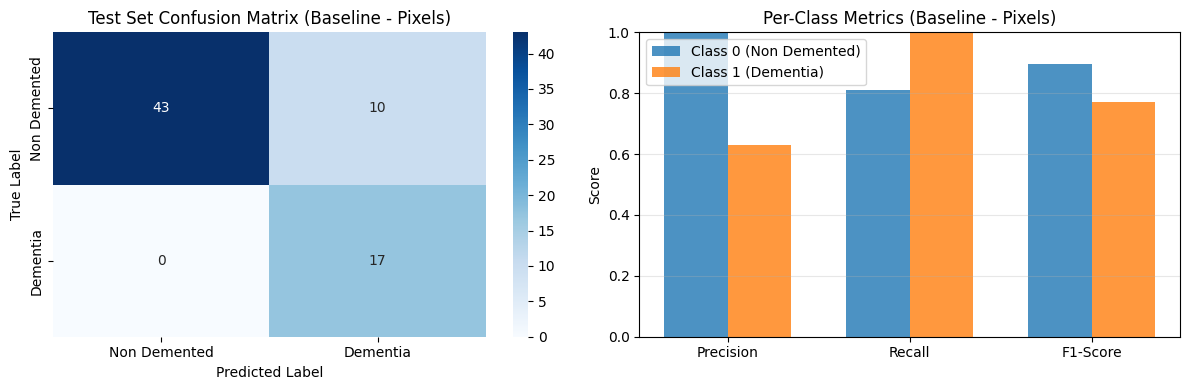


Training Complete!
Best Class 1 F1-Score (Val): 0.6875
Test Class 1 F1-Score: 0.7727


In [ ]:
"""
3D CNN Baseline Model - Raw Pixels for Alzheimer's Disease Classification
OASIS-1 Dataset - Uses same architecture but with pixel inputs instead of features

Key Differences from Feature Extraction Pipeline:
1. Input: Raw pixels (1, 32, 256, 256) instead of features (512, 32, 8, 8)
2. No pretrained ResNet-18 feature extraction
3. Same 3D CNN architecture adapted for pixel inputs
4. Uses EXACT same train/val/test split from patient.json
"""

import os
import re
import json
import numpy as np
from collections import defaultdict
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

# Scikit-learn imports
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# CONFIGURATION
# ============================================================================

# Dataset configuration
DATA_ROOT = '/kaggle/input/imagesoasis/Data'
PATIENT_SPLIT_JSON = '/kaggle/input/patient-split-1/patient_split.json'  # Path to your patient split JSON
CLASS_MAPPING = {
    'Non Demented': 0,
    'Very mild Dementia': 1,
    'Mild Dementia': 1,
    'Moderate Dementia': 1
}

# Preprocessing configuration
PREPROCESSING_REMOVE_DARK_SLICES = 20
PREPROCESSING_TARGET_DEPTH = 32
TARGET_SIZE = 256  # Image size (256x256)

# Training configuration
BATCH_SIZE = 4  # Smaller batch size due to larger input
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_PATIENCE = 10

# Random seed (should match patient.json)
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def extract_patient_id(filename):
    """Extract patient ID from OASIS-1 filename"""
    match = re.search(r'OAS1_(\d+)_', filename)
    return int(match.group(1)) if match else None

def extract_slice_number(filename):
    """Extract slice number from OASIS-1 filename"""
    match = re.search(r'_(\d+)\.(jpg|jpeg|png)$', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None

def load_patient_split(json_path):
    """Load patient split from JSON file"""
    with open(json_path, 'r') as f:
        split_data = json.load(f)
    return split_data

# ============================================================================
# DATA LOADING
# ============================================================================

def load_slices_by_patient(data_root, class_mapping):
    """
    Load all slices and organize by patient ID

    Returns:
        patient_slices: {patient_id: {'slices': [{'path': str, 'slice_num': int}],
                                      'label': int, 'class': str}}
    """
    patient_slices = defaultdict(lambda: {'slices': [], 'label': None, 'class': None})

    for class_name, class_label in class_mapping.items():
        class_dir = os.path.join(data_root, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found, skipping...")
            continue

        for filename in os.listdir(class_dir):
            if not filename.endswith(('.jpg', '.jpeg', '.png')):
                continue

            patient_id = extract_patient_id(filename)
            slice_num = extract_slice_number(filename)

            if patient_id is None or slice_num is None:
                continue

            img_path = os.path.join(class_dir, filename)
            patient_slices[patient_id]['slices'].append({
                'path': img_path,
                'slice_num': slice_num,
                'filename': filename
            })
            patient_slices[patient_id]['label'] = class_label
            patient_slices[patient_id]['class'] = class_name

    # Sort slices by slice number for each patient
    for patient_id in patient_slices:
        patient_slices[patient_id]['slices'].sort(key=lambda x: x['slice_num'])

    return dict(patient_slices)

# ============================================================================
# PIXEL VOLUME PROCESSING
# ============================================================================

def load_slice_as_pixel(img_path, target_size=256):
    """Load single slice as normalized pixel array"""
    img = Image.open(img_path).convert('L')  # Grayscale
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)

    # Convert to numpy array and normalize to [0, 1]
    pixel_array = np.array(img, dtype=np.float32) / 255.0

    return pixel_array  # (256, 256)

def load_pixel_volume_from_patient(patient_data, target_size=256):
    """
    Load all slices as pixel volume

    Args:
        patient_data: {'slices': [{'path': str, 'slice_num': int}], 'label': int}
        target_size: Image size

    Returns:
        pixel_volume: np.array of shape (num_slices, target_size, target_size)
    """
    slices = patient_data['slices']
    pixel_slices = []

    for slice_info in slices:
        pixel_array = load_slice_as_pixel(slice_info['path'], target_size)
        pixel_slices.append(pixel_array)

    # Stack into 3D volume: (num_slices, H, W)
    pixel_volume = np.stack(pixel_slices, axis=0)

    return pixel_volume

def remove_dark_slices(pixel_volume, n_slices=20):
    """
    Remove n darkest slices from pixel volume

    Args:
        pixel_volume: (num_slices, H, W)
        n_slices: Number of dark slices to remove

    Returns:
        cleaned_volume: (num_slices - n, H, W)
    """
    num_slices = pixel_volume.shape[0]

    if num_slices <= n_slices:
        return pixel_volume

    # Calculate mean intensity per slice
    slice_intensities = []
    for i in range(num_slices):
        mean_intensity = np.mean(pixel_volume[i])
        slice_intensities.append((i, mean_intensity))

    # Sort by intensity and get indices to remove
    slice_intensities.sort(key=lambda x: x[1])
    slices_to_remove = {idx for idx, _ in slice_intensities[:n_slices]}

    # Keep valid slices
    valid_indices = [i for i in range(num_slices) if i not in slices_to_remove]
    cleaned_volume = pixel_volume[valid_indices]

    return cleaned_volume

def normalize_pixel_volume(pixel_volume):
    """
    Normalize pixel volume (volume-level normalization)

    Args:
        pixel_volume: (num_slices, H, W)

    Returns:
        normalized_volume: (num_slices, H, W)
    """
    mean = np.mean(pixel_volume)
    std = np.std(pixel_volume)

    if std > 0:
        normalized = (pixel_volume - mean) / (std + 1e-8)
    else:
        normalized = pixel_volume

    return normalized.astype(np.float32)

def resize_pixel_volume(pixel_volume, target_depth=32):
    """
    Resize pixel volume to target depth using interpolation

    Args:
        pixel_volume: (num_slices, H, W)
        target_depth: Target number of slices

    Returns:
        resized_volume: (target_depth, H, W)
    """
    from scipy.ndimage import zoom

    current_depth = pixel_volume.shape[0]

    if current_depth == target_depth:
        return pixel_volume

    # Calculate zoom factor for depth dimension
    zoom_factor = target_depth / current_depth
    zoom_factors = (zoom_factor, 1.0, 1.0)
    resized = zoom(pixel_volume, zoom_factors, order=1)

    return resized.astype(np.float32)

# ============================================================================
# DATA SPLITTING (USING patient.json)
# ============================================================================

def split_by_patient_json(pixel_volumes_dict, split_data):
    """
    Split pixel volumes using predefined patient IDs from JSON

    Args:
        pixel_volumes_dict: {patient_id: {'pixels': np.array, 'label': int}}
        split_data: Dictionary from patient.json

    Returns:
        train_dict, val_dict, test_dict
    """
    train_patients = set(split_data['train_patients'])
    val_patients = set(split_data['val_patients'])
    test_patients = set(split_data['test_patients'])

    train_dict = {pid: pixel_volumes_dict[pid] for pid in train_patients if pid in pixel_volumes_dict}
    val_dict = {pid: pixel_volumes_dict[pid] for pid in val_patients if pid in pixel_volumes_dict}
    test_dict = {pid: pixel_volumes_dict[pid] for pid in test_patients if pid in pixel_volumes_dict}

    return train_dict, val_dict, test_dict

# ============================================================================
# DATASET CLASS
# ============================================================================

class PixelVolumeDataset(Dataset):
    """
    Dataset for 3D pixel volumes
    Input: Pixel volumes of shape (depth, height, width)
    """
    def __init__(self, pixel_volumes_dict):
        """
        Args:
            pixel_volumes_dict: {patient_id: {'pixels': np.array, 'label': int}}
        """
        self.patient_ids = list(pixel_volumes_dict.keys())
        self.pixels = [pixel_volumes_dict[pid]['pixels'] for pid in self.patient_ids]
        self.labels = [pixel_volumes_dict[pid]['label'] for pid in self.patient_ids]

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        """
        Returns:
            pixels: torch.Tensor of shape (1, depth, height, width)
                   e.g., (1, 32, 256, 256)
            label: int (0 or 1)
        """
        pixels = self.pixels[idx]  # (depth, height, width) = (32, 256, 256)
        label = self.labels[idx]

        # Convert to tensor and add channel dimension
        pixels = torch.FloatTensor(pixels).unsqueeze(0)  # (1, 32, 256, 256)
        label = torch.LongTensor([label])[0]

        return pixels, label

# ============================================================================
# 3D CNN MODEL (ADAPTED FOR PIXELS)
# ============================================================================

class ResNet18_3D_Pixels(nn.Module):
    """
    3D CNN for raw pixel volumes (baseline model)
    Input: (batch, 1, depth, height, width) - pixel volumes

    Architecture mirrors the feature-based model but adapted for pixel inputs
    """
    def __init__(self, num_classes=2):
        super().__init__()

        # Input: (batch, 1, 32, 256, 256)
        # First 3D conv block - reduce spatial dimensions significantly
        self.conv3d_block1 = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3)),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 3, 3), stride=(2, 2, 2), padding=(0, 1, 1))
            # Output: (batch, 64, 16, 64, 64)
        )

        # Second 3D conv block
        self.conv3d_block2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
            # Output: (batch, 128, 8, 32, 32)
        )

        # Third 3D conv block
        self.conv3d_block3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2))
            # Output: (batch, 256, 4, 16, 16)
        )

        # Fourth 3D conv block
        self.conv3d_block4 = nn.Sequential(
            nn.Conv3d(256, 128, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1, 1, 1))
            # Output: (batch, 128, 1, 1, 1)
        )

        # Classifier (similar to feature-based model)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        """
        Args:
            x: (batch, 1, depth, height, width) - pixel volume
        Returns:
            logits: (batch, num_classes)
        """
        x = self.conv3d_block1(x)
        x = self.conv3d_block2(x)
        x = self.conv3d_block3(x)
        x = self.conv3d_block4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Classify
        x = self.classifier(x)

        return x

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc='Training')
    for pixels, labels in pbar:
        pixels, labels = pixels.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(pixels)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': loss.item(), 'acc': 100*correct/total})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validating')
        for pixels, labels in pbar:
            pixels, labels = pixels.to(device), labels.to(device)

            outputs = model(pixels)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({'loss': loss.item(), 'acc': 100*correct/total})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )

    return epoch_loss, epoch_acc, precision, recall, f1, all_preds, all_labels

# ============================================================================
# MAIN FUNCTION
# ============================================================================

def main():
    """Main training pipeline"""
    print("="*70)
    print("3D CNN Baseline Model - Raw Pixels")
    print("Alzheimer's Disease Classification")
    print("="*70)

    # Step 1: Load patient split
    print("\n[Step 1] Loading patient split from JSON...")
    if not os.path.exists(PATIENT_SPLIT_JSON):
        raise FileNotFoundError(f"Patient split file not found: {PATIENT_SPLIT_JSON}")

    split_data = load_patient_split(PATIENT_SPLIT_JSON)
    print(f"Loaded split with seed: {split_data['random_seed']}")
    print(f"Train patients: {len(split_data['train_patients'])}")
    print(f"Val patients: {len(split_data['val_patients'])}")
    print(f"Test patients: {len(split_data['test_patients'])}")

    # Step 2: Load slices
    print("\n[Step 2] Loading 2D slices...")
    patient_slices = load_slices_by_patient(DATA_ROOT, CLASS_MAPPING)
    print(f"Loaded {len(patient_slices)} patients")

    # Step 3: Load pixel volumes
    print("\n[Step 3] Loading pixel volumes from slices...")
    pixel_volumes_dict = {}

    for patient_id, patient_data in tqdm(patient_slices.items(), desc="Processing"):
        pixels = load_pixel_volume_from_patient(patient_data, target_size=TARGET_SIZE)

        pixel_volumes_dict[patient_id] = {
            'pixels': pixels,
            'label': patient_data['label'],
            'class': patient_data['class']
        }

    print(f"Pixel volume loading complete!")
    sample_shape = pixel_volumes_dict[list(pixel_volumes_dict.keys())[0]]['pixels'].shape
    print(f"Sample pixel volume shape: {sample_shape}")

    # Step 4: Preprocessing
    print("\n[Step 4] Applying preprocessing...")
    processed_pixels = {}

    for patient_id, data in tqdm(pixel_volumes_dict.items(), desc="Preprocessing"):
        pixels = data['pixels']

        # Remove dark slices
        pixels = remove_dark_slices(pixels, n_slices=PREPROCESSING_REMOVE_DARK_SLICES)

        # Normalize
        pixels = normalize_pixel_volume(pixels)

        # Resize to standard depth
        pixels = resize_pixel_volume(pixels, target_depth=PREPROCESSING_TARGET_DEPTH)

        processed_pixels[patient_id] = {
            'pixels': pixels,
            'label': data['label'],
            'class': data['class']
        }

    print(f"Preprocessing complete!")
    sample_shape = processed_pixels[list(processed_pixels.keys())[0]]['pixels'].shape
    print(f"Processed pixel volume shape: {sample_shape}")

    # Step 5: Split using patient.json
    print("\n[Step 5] Splitting by patient ID (using patient.json)...")
    train_pixels, val_pixels, test_pixels = split_by_patient_json(processed_pixels, split_data)

    print(f"Train: {len(train_pixels)} patients")
    print(f"Val: {len(val_pixels)} patients")
    print(f"Test: {len(test_pixels)} patients")

    # Check class distribution
    train_labels = [data['label'] for data in train_pixels.values()]
    val_labels = [data['label'] for data in val_pixels.values()]
    test_labels = [data['label'] for data in test_pixels.values()]

    print(f"\nClass distribution:")
    print(f"  Train - Class 0: {sum(1 for l in train_labels if l == 0)}, Class 1: {sum(1 for l in train_labels if l == 1)}")
    print(f"  Val - Class 0: {sum(1 for l in val_labels if l == 0)}, Class 1: {sum(1 for l in val_labels if l == 1)}")
    print(f"  Test - Class 0: {sum(1 for l in test_labels if l == 0)}, Class 1: {sum(1 for l in test_labels if l == 1)}")

    # Step 6: Create datasets
    print("\n[Step 6] Creating PyTorch datasets...")
    train_dataset = PixelVolumeDataset(train_pixels)
    val_dataset = PixelVolumeDataset(val_pixels)
    test_dataset = PixelVolumeDataset(test_pixels)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # Verify shape
    for pixels, labels in train_loader:
        print(f"Batch shape: {pixels.shape}")  # (batch, 1, 32, 256, 256)
        print(f"Labels shape: {labels.shape}")
        break

    # Step 7: Initialize model
    print("\n[Step 7] Initializing 3D CNN baseline model...")
    model = ResNet18_3D_Pixels(num_classes=2).to(device)
    print(f"Model initialized on {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

    # Step 8: Setup training
    print("\n[Step 8] Setting up training...")
    train_labels_array = np.array(train_labels)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_labels_array),
        y=train_labels_array
    )
    class_weights = torch.FloatTensor(class_weights).to(device)
    print(f"Class weights: {class_weights}")

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    # Step 9: Training loop
    print("\n[Step 9] Starting training...")
    print("="*70)

    best_val_f1 = 0.0
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        print("-" * 70)

        train_loss, train_acc, train_preds, train_labels = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss, val_acc, val_precision, val_recall, val_f1, val_preds, val_labels = validate(
            model, val_loader, criterion, device
        )

        scheduler.step(val_loss)

        current_f1 = val_f1[1]

        if current_f1 > best_val_f1:
            best_val_f1 = current_f1
            epochs_no_improve = 0
            best_model_state = model.state_dict().copy()
            print(f"✓ New best Class 1 F1: {best_val_f1:.4f}")
        else:
            epochs_no_improve += 1
            print(f"Class 1 F1 not improved. Patience: {epochs_no_improve}/{EARLY_STOPPING_PATIENCE}")

        print(f"\nTrain - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"Val - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        print(f"Val - Class 0 F1: {val_f1[0]:.4f}, Class 1 F1: {val_f1[1]:.4f}")

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered!")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    # Step 10: Evaluation
    print("\n[Step 10] Evaluating on test set...")
    print("="*70)

    test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_labels = validate(
        model, test_loader, criterion, device
    )

    print(f"\nTest Results:")
    print(f"Overall Accuracy: {test_acc:.2f}%")
    print(f"Class 0 - Precision: {test_precision[0]:.4f}, Recall: {test_recall[0]:.4f}, F1: {test_f1[0]:.4f}")
    print(f"Class 1 - Precision: {test_precision[1]:.4f}, Recall: {test_recall[1]:.4f}, F1: {test_f1[1]:.4f}")

    print("\n" + "="*70)
    print("Classification Report:")
    print("="*70)
    class_names = ['Non Demented', 'Dementia']
    print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(test_labels, test_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Save model
    print("\nSaving model...")
    torch.save(model.state_dict(), '3d_cnn_baseline_pixels_model.pth')
    print("Model saved to '3d_cnn_baseline_pixels_model.pth'")

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Test Set Confusion Matrix (Baseline - Pixels)')

    plt.subplot(1, 2, 2)
    metrics = ['Precision', 'Recall', 'F1-Score']
    class0_metrics = [test_precision[0], test_recall[0], test_f1[0]]
    class1_metrics = [test_precision[1], test_recall[1], test_f1[1]]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, class0_metrics, width, label='Class 0 (Non Demented)', alpha=0.8)
    plt.bar(x + width/2, class1_metrics, width, label='Class 1 (Dementia)', alpha=0.8)

    plt.ylabel('Score')
    plt.title('Per-Class Metrics (Baseline - Pixels)')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim([0, 1])
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('3d_cnn_baseline_results.png', dpi=300, bbox_inches='tight')
    print("Results saved to '3d_cnn_baseline_results.png'")
    plt.show()

    print("\n" + "="*70)
    print("Training Complete!")
    print("="*70)
    print(f"Best Class 1 F1-Score (Val): {best_val_f1:.4f}")
    print(f"Test Class 1 F1-Score: {test_f1[1]:.4f}")
    print("="*70)

if __name__ == '__main__':
    main()

## Pretrained Model (MedicalNet)

Using device: cpu
MedicalNet ResNet-18 for Alzheimer's Classification
Pretrained on Medical CT Scans (Domain-Specific!)
Classification Threshold: 0.35

[1/8] Loading patient split...
✓ Train: 208, Val: 69, Test: 70

[2/8] Loading metadata...
✓ 347 patients

[3/8] Splitting data...
✓ Train: 208, Val: 69, Test: 70

[4/8] Creating datasets...

[4.5/8] Creating WeightedRandomSampler for class balance...
✓ Class counts: Class 0=158, Class 1=50
✓ Class weights: [0.00632911 0.02      ]
✓ Sampler will balance classes during training
✓ Batch shape: torch.Size([4, 1, 32, 224, 224])

[5/8] Initializing MedicalNet ResNet-18...
✓ Loaded MedicalNet pretrained weights
✓ Backbone frozen
✓ Total: 33.3M, Trainable: 0.1M

[6/8] Setting up training...
✓ Using weighted CrossEntropyLoss: [1. 3.]
✓ Combined with WeightedRandomSampler for class balance

[7/8] Training...

Epoch 1/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:37<00:00,  2.09s/it, loss=0.876, acc=20.3]


✓ New best F1: 0.3373
Train - Loss: 0.6679, Acc: 46.63%
Val   - Loss: 0.7566, Acc: 20.29%
Val   - P: 0.2029, R: 1.0000, F1: 0.3373
Patience: 0/10

Epoch 2/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:35<00:00,  1.97s/it, loss=1.04, acc=20.3] 


Train - Loss: 0.6017, Acc: 51.44%
Val   - Loss: 0.8458, Acc: 20.29%
Val   - P: 0.2029, R: 1.0000, F1: 0.3373
Patience: 1/10

Epoch 3/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it, loss=0.86, acc=20.3] 


Train - Loss: 0.6733, Acc: 46.63%
Val   - Loss: 0.7490, Acc: 20.29%
Val   - P: 0.2029, R: 1.0000, F1: 0.3373
Patience: 2/10

Epoch 4/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:35<00:00,  1.98s/it, loss=0.86, acc=20.3] 


Train - Loss: 0.6461, Acc: 46.63%
Val   - Loss: 0.7663, Acc: 20.29%
Val   - P: 0.2029, R: 1.0000, F1: 0.3373
Patience: 3/10

Epoch 5/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:36<00:00,  2.03s/it, loss=1.19, acc=20.3] 


Train - Loss: 0.5941, Acc: 55.29%
Val   - Loss: 0.9060, Acc: 20.29%
Val   - P: 0.2029, R: 1.0000, F1: 0.3373
Patience: 4/10

Epoch 6/50
----------------------------------------------------------------------
✓ Backbone unfrozen


Validating: 100%|██████████| 18/18 [00:34<00:00,  1.92s/it, loss=0.494, acc=23.2]


✓ New best F1: 0.3457
Train - Loss: 0.6107, Acc: 47.60%
Val   - Loss: 0.5446, Acc: 23.19%
Val   - P: 0.2090, R: 1.0000, F1: 0.3457
Patience: 0/10

Epoch 7/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:33<00:00,  1.89s/it, loss=0.876, acc=65.2]


✓ New best F1: 0.5385
Train - Loss: 0.5295, Acc: 56.73%
Val   - Loss: 0.5944, Acc: 65.22%
Val   - P: 0.3684, R: 1.0000, F1: 0.5385
Patience: 0/10

Epoch 8/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:35<00:00,  2.00s/it, loss=0.832, acc=66.7]


Train - Loss: 0.4926, Acc: 68.27%
Val   - Loss: 0.6144, Acc: 66.67%
Val   - P: 0.3714, R: 0.9286, F1: 0.5306
Patience: 1/10

Epoch 9/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:35<00:00,  1.97s/it, loss=0.214, acc=82.6]


✓ New best F1: 0.6667
Train - Loss: 0.4647, Acc: 61.06%
Val   - Loss: 0.4151, Acc: 82.61%
Val   - P: 0.5455, R: 0.8571, F1: 0.6667
Patience: 0/10

Epoch 10/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:36<00:00,  2.03s/it, loss=1.15, acc=68.1] 


Train - Loss: 0.5199, Acc: 69.23%
Val   - Loss: 0.4889, Acc: 68.12%
Val   - P: 0.3824, R: 0.9286, F1: 0.5417
Patience: 1/10

Epoch 11/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:34<00:00,  1.91s/it, loss=1.11, acc=56.5] 


Train - Loss: 0.3933, Acc: 73.56%
Val   - Loss: 0.7247, Acc: 56.52%
Val   - P: 0.3182, R: 1.0000, F1: 0.4828
Patience: 2/10

Epoch 12/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:34<00:00,  1.94s/it, loss=0.51, acc=60.9] 


Train - Loss: 0.4544, Acc: 69.23%
Val   - Loss: 0.5610, Acc: 60.87%
Val   - P: 0.3415, R: 1.0000, F1: 0.5091
Patience: 3/10

Epoch 13/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:36<00:00,  2.02s/it, loss=0.246, acc=72.5] 


Train - Loss: 0.4092, Acc: 67.79%
Val   - Loss: 0.4482, Acc: 72.46%
Val   - P: 0.4138, R: 0.8571, F1: 0.5581
Patience: 4/10

Epoch 14/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:34<00:00,  1.94s/it, loss=1.91, acc=59.4] 


Train - Loss: 0.3380, Acc: 72.12%
Val   - Loss: 0.9210, Acc: 59.42%
Val   - P: 0.3250, R: 0.9286, F1: 0.4815
Patience: 5/10

Epoch 15/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:35<00:00,  1.97s/it, loss=0.11, acc=72.5]  


Train - Loss: 0.3567, Acc: 75.48%
Val   - Loss: 0.5614, Acc: 72.46%
Val   - P: 0.4138, R: 0.8571, F1: 0.5581
Patience: 6/10

Epoch 16/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:36<00:00,  2.04s/it, loss=0.413, acc=84.1] 


✓ New best F1: 0.6857
Train - Loss: 0.3909, Acc: 75.96%
Val   - Loss: 0.4138, Acc: 84.06%
Val   - P: 0.5714, R: 0.8571, F1: 0.6857
Patience: 0/10

Epoch 17/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:36<00:00,  2.03s/it, loss=0.101, acc=84.1] 


Train - Loss: 0.4221, Acc: 79.81%
Val   - Loss: 0.4237, Acc: 84.06%
Val   - P: 0.5714, R: 0.8571, F1: 0.6857
Patience: 1/10

Epoch 18/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:36<00:00,  2.05s/it, loss=0.338, acc=72.5] 


Train - Loss: 0.3998, Acc: 78.37%
Val   - Loss: 0.5305, Acc: 72.46%
Val   - P: 0.4000, R: 0.7143, F1: 0.5128
Patience: 2/10

Epoch 19/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:33<00:00,  1.88s/it, loss=0.108, acc=68.1]


Train - Loss: 0.3092, Acc: 84.13%
Val   - Loss: 0.5649, Acc: 68.12%
Val   - P: 0.3824, R: 0.9286, F1: 0.5417
Patience: 3/10

Epoch 20/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:32<00:00,  1.83s/it, loss=0.0832, acc=82.6]


Train - Loss: 0.3192, Acc: 80.77%
Val   - Loss: 0.4044, Acc: 82.61%
Val   - P: 0.5455, R: 0.8571, F1: 0.6667
Patience: 4/10

Epoch 21/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:35<00:00,  1.96s/it, loss=0.843, acc=63.8] 


Train - Loss: 0.3462, Acc: 83.17%
Val   - Loss: 0.6204, Acc: 63.77%
Val   - P: 0.3333, R: 0.7857, F1: 0.4681
Patience: 5/10

Epoch 22/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:32<00:00,  1.82s/it, loss=0.538, acc=68.1]


Train - Loss: 0.2845, Acc: 87.02%
Val   - Loss: 0.6044, Acc: 68.12%
Val   - P: 0.3750, R: 0.8571, F1: 0.5217
Patience: 6/10

Epoch 23/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:32<00:00,  1.80s/it, loss=0.0814, acc=82.6]


Train - Loss: 0.2543, Acc: 83.65%
Val   - Loss: 0.5764, Acc: 82.61%
Val   - P: 0.5625, R: 0.6429, F1: 0.6000
Patience: 7/10

Epoch 24/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:33<00:00,  1.84s/it, loss=0.146, acc=72.5] 


Train - Loss: 0.1490, Acc: 92.79%
Val   - Loss: 0.6760, Acc: 72.46%
Val   - P: 0.4138, R: 0.8571, F1: 0.5581
Patience: 8/10

Epoch 25/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:35<00:00,  1.98s/it, loss=0.249, acc=78.3] 


Train - Loss: 0.1847, Acc: 90.38%
Val   - Loss: 0.7864, Acc: 78.26%
Val   - P: 0.4667, R: 0.5000, F1: 0.4828
Patience: 9/10

Epoch 26/50
----------------------------------------------------------------------


Validating: 100%|██████████| 18/18 [00:37<00:00,  2.09s/it, loss=0.0162, acc=81.2] 


Train - Loss: 0.2236, Acc: 88.94%
Val   - Loss: 0.5957, Acc: 81.16%
Val   - P: 0.5263, R: 0.7143, F1: 0.6061
Patience: 10/10
Early stopping!

[8/8] Evaluating...


Validating: 100%|██████████| 18/18 [00:38<00:00,  2.12s/it, loss=0.0281, acc=90]  



TEST RESULTS (MedicalNet)
Accuracy: 90.00%
Class 0 - P: 0.9423, R: 0.9245, F1: 0.9333
Class 1 - P: 0.7778, R: 0.8235, F1: 0.8000

              precision    recall  f1-score   support

Non Demented     0.9423    0.9245    0.9333        53
    Dementia     0.7778    0.8235    0.8000        17

    accuracy                         0.9000        70
   macro avg     0.8600    0.8740    0.8667        70
weighted avg     0.9024    0.9000    0.9010        70


Confusion Matrix:
[[49  4]
 [ 3 14]]

Saving model...


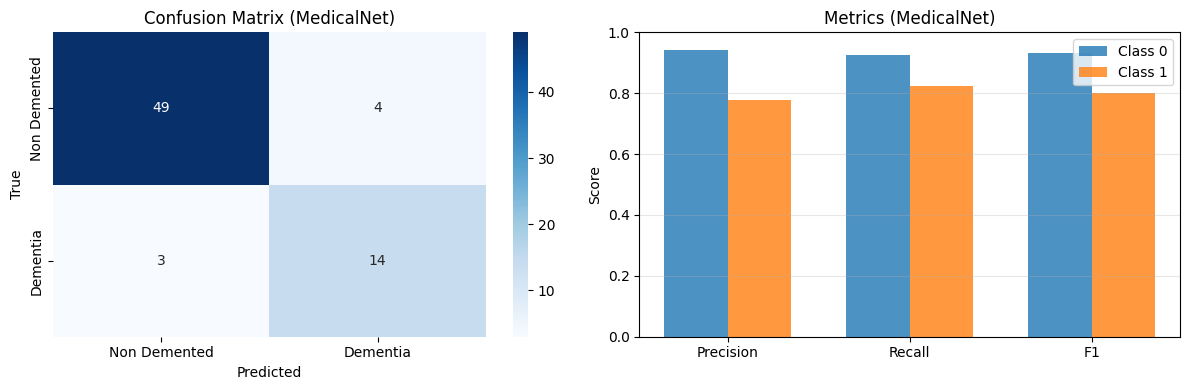


COMPLETE!
Best Val F1: 0.6857
Test F1: 0.8000


In [ ]:
"""
MedicalNet Pretrained Model for Alzheimer's Disease Classification
OASIS-1 Dataset - Uses MedicalNet (pretrained on medical CT scans)

Key Features:
1. MedicalNet ResNet-18 pretrained on medical imaging (much better than Kinetics!)
2. Domain-specific features from 3D medical scans
3. Fine-tuned end-to-end for Alzheimer's classification
4. On-the-fly loading for memory efficiency
"""

import os
import re
import json
import numpy as np
from collections import defaultdict
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

# Scikit-learn imports
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# CONFIGURATION
# ============================================================================

# Dataset configuration
DATA_ROOT = '/kaggle/input/imagesoasis/Data'
PATIENT_SPLIT_JSON = '/kaggle/input/patient-split-1/patient_split.json'
MEDICALNET_WEIGHTS = '/kaggle/input/resnet18-23dataset/pytorch/default/1/resnet_18_23dataset.pth'

CLASS_MAPPING = {
    'Non Demented': 0,
    'Very mild Dementia': 1,
    'Mild Dementia': 1,
    'Moderate Dementia': 1
}

# Preprocessing configuration
PREPROCESSING_REMOVE_DARK_SLICES = 20
PREPROCESSING_TARGET_DEPTH = 32
TARGET_SIZE = 224

# Training configuration
BATCH_SIZE = 4
ACCUMULATION_STEPS = 2
NUM_WORKERS = 4
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_PATIENCE = 10
USE_AMP = True
FREEZE_BACKBONE_EPOCHS = 5

# Classification threshold for inference
CLASSIFICATION_THRESHOLD = 0.35  # Lowering increases recall

# Random seed
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def extract_patient_id(filename):
    """Extract patient ID from OASIS-1 filename"""
    match = re.search(r'OAS1_(\d+)_', filename)
    return int(match.group(1)) if match else None

def extract_slice_number(filename):
    """Extract slice number from OASIS-1 filename"""
    match = re.search(r'_(\d+)\.(jpg|jpeg|png)$', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None

def load_patient_split(json_path):
    """Load patient split from JSON file"""
    with open(json_path, 'r') as f:
        split_data = json.load(f)
    return split_data

# ============================================================================
# DATA LOADING
# ============================================================================

def load_slices_by_patient(data_root, class_mapping):
    """Load slice metadata organized by patient ID"""
    patient_slices = defaultdict(lambda: {'slices': [], 'label': None, 'class': None})

    for class_name, class_label in class_mapping.items():
        class_dir = os.path.join(data_root, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found, skipping...")
            continue

        for filename in os.listdir(class_dir):
            if not filename.endswith(('.jpg', '.jpeg', '.png')):
                continue

            patient_id = extract_patient_id(filename)
            slice_num = extract_slice_number(filename)

            if patient_id is None or slice_num is None:
                continue

            img_path = os.path.join(class_dir, filename)
            patient_slices[patient_id]['slices'].append({
                'path': img_path,
                'slice_num': slice_num
            })
            patient_slices[patient_id]['label'] = class_label
            patient_slices[patient_id]['class'] = class_name

    for patient_id in patient_slices:
        patient_slices[patient_id]['slices'].sort(key=lambda x: x['slice_num'])

    return dict(patient_slices)

def split_by_patient_json(patient_slices, split_data):
    """Split using patient.json"""
    train_patients = set(split_data['train_patients'])
    val_patients = set(split_data['val_patients'])
    test_patients = set(split_data['test_patients'])

    train_dict = {pid: patient_slices[pid] for pid in train_patients if pid in patient_slices}
    val_dict = {pid: patient_slices[pid] for pid in val_patients if pid in patient_slices}
    test_dict = {pid: patient_slices[pid] for pid in test_patients if pid in patient_slices}

    return train_dict, val_dict, test_dict

# ============================================================================
# OPTIMIZED PREPROCESSING
# ============================================================================

def load_slice_as_grayscale(img_path, target_size=224):
    """Load slice as grayscale (MedicalNet uses single channel)"""
    img = Image.open(img_path).convert('L')
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr

def load_and_process_volume_fast(slice_paths, target_size=224, target_depth=32, remove_dark=20):
    """Fast volume loading for MedicalNet"""
    # Load all slices
    slices = [load_slice_as_grayscale(p, target_size) for p in slice_paths]
    volume = np.stack(slices, axis=0)

    # Focus on brain center (hippocampus region) - slice selection
    if len(volume) > target_depth:
        start_idx = int(len(volume) * 0.15)
        end_idx = int(len(volume) * 0.85)
        volume = volume[start_idx:end_idx]

    # Resize depth to target_depth
    if len(volume) != target_depth:
        indices = np.linspace(0, len(volume) - 1, target_depth)
        indices_floor = np.floor(indices).astype(int)
        indices_ceil = np.ceil(indices).astype(int)
        weights = indices - indices_floor

        volume_resized = []
        for f, c, w in zip(indices_floor, indices_ceil, weights):
            if f == c:
                volume_resized.append(volume[f])
            else:
                interpolated = volume[f] * (1 - w) + volume[c] * w
                volume_resized.append(interpolated)

        volume = np.stack(volume_resized, axis=0)

    # Add channel dimension: (D, H, W) -> (1, D, H, W)
    volume = np.expand_dims(volume, axis=0)

    # Normalize (Z-score normalization)
    mean = volume.mean()
    std = volume.std()
    if std > 0:
        volume = (volume - mean) / (std + 1e-8)

    return volume.astype(np.float32)

# ============================================================================
# DATASET
# ============================================================================

class MedicalNetDataset(Dataset):
    """Dataset for MedicalNet (grayscale volumes)"""
    def __init__(self, patient_metadata_dict, target_size=224, target_depth=32, remove_dark=20):
        self.patient_ids = list(patient_metadata_dict.keys())
        self.patient_metadata = patient_metadata_dict
        self.target_size = target_size
        self.target_depth = target_depth
        self.remove_dark = remove_dark
        self.labels = [patient_metadata_dict[pid]['label'] for pid in self.patient_ids]

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        patient_data = self.patient_metadata[patient_id]

        slice_paths = [s['path'] for s in patient_data['slices']]

        volume = load_and_process_volume_fast(
            slice_paths,
            target_size=self.target_size,
            target_depth=self.target_depth,
            remove_dark=self.remove_dark
        )

        pixels = torch.from_numpy(volume)  # (1, D, H, W)
        label = torch.tensor(patient_data['label'], dtype=torch.long)

        return pixels, label

# ============================================================================
# MEDICALNET RESNET-18 MODEL
# ============================================================================

class MedicalNetResNet18(nn.Module):
    """
    MedicalNet ResNet-18 for binary classification
    Pretrained on medical CT scans - much better domain match!
    """
    def __init__(self, num_classes=2, pretrained_path=None, freeze_backbone=False):
        super().__init__()

        # Build ResNet-18 3D architecture (same as MedicalNet)
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        # ResNet blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))

        # Load pretrained weights
        if pretrained_path and os.path.exists(pretrained_path):
            self._load_pretrained_weights(pretrained_path)
            print("✓ Loaded MedicalNet pretrained weights")
        else:
            print("⚠ No pretrained weights found, training from scratch")

        # Freeze backbone if requested
        if freeze_backbone:
            for name, param in self.named_parameters():
                if 'fc' not in name:
                    param.requires_grad = False
            print("✓ Backbone frozen")

        # Custom classifier for binary classification
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        """Create ResNet layer"""
        layers = []

        # First block (may downsample)
        layers.append(BasicBlock3D(in_channels, out_channels, stride))

        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(BasicBlock3D(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def _load_pretrained_weights(self, pretrained_path):
        """Load MedicalNet pretrained weights"""
        try:
            pretrained_dict = torch.load(pretrained_path, map_location='cpu')

            # Handle different checkpoint formats
            if 'state_dict' in pretrained_dict:
                pretrained_dict = pretrained_dict['state_dict']

            # Remove 'module.' prefix if present
            pretrained_dict = {k.replace('module.', ''): v for k, v in pretrained_dict.items()}

            # Filter out fc layer (we'll train our own)
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith('fc')}

            # Load weights
            model_dict = self.state_dict()
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict, strict=False)

        except Exception as e:
            print(f"⚠ Error loading pretrained weights: {e}")
            print("Training from scratch...")

    def unfreeze_backbone(self):
        """Unfreeze backbone for fine-tuning"""
        for param in self.parameters():
            param.requires_grad = True
        print("✓ Backbone unfrozen")

    def forward(self, x):
        # x: (batch, 1, D, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.fc(x)

        return x

class BasicBlock3D(nn.Module):
    """3D BasicBlock for ResNet"""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Shortcut connection
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None, accumulation_steps=1):
    """Train with gradient accumulation and mixed precision"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    optimizer.zero_grad()

    pbar = tqdm(dataloader, desc='Training')
    for i, (pixels, labels) in enumerate(pbar):
        pixels, labels = pixels.to(device), labels.to(device)

        if scaler is not None:
            with autocast():
                outputs = model(pixels)
                loss = criterion(outputs, labels) / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        else:
            outputs = model(pixels)
            loss = criterion(outputs, labels) / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps

        # Use custom threshold during training for better metrics tracking
        probs = torch.softmax(outputs, dim=1)
        predicted = (probs[:, 1] >= CLASSIFICATION_THRESHOLD).long()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': running_loss/(i+1), 'acc': 100*correct/total})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

def validate(model, dataloader, criterion, device):
    """Validate with custom threshold"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validating')
        for pixels, labels in pbar:
            pixels, labels = pixels.to(device), labels.to(device)

            with autocast():
                outputs = model(pixels)
                loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Use custom threshold
            probs = torch.softmax(outputs, dim=1)
            predicted = (probs[:, 1] >= CLASSIFICATION_THRESHOLD).long()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({'loss': loss.item(), 'acc': 100*correct/total})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )

    return epoch_loss, epoch_acc, precision, recall, f1, all_preds, all_labels

# ============================================================================
# MAIN FUNCTION
# ============================================================================

def main():
    """Main pipeline with MedicalNet"""
    print("="*70)
    print("MedicalNet ResNet-18 for Alzheimer's Classification")
    print("Pretrained on Medical CT Scans (Domain-Specific!)")
    print("="*70)
    print(f"Classification Threshold: {CLASSIFICATION_THRESHOLD}")

    # Load patient split
    print("\n[1/8] Loading patient split...")
    split_data = load_patient_split(PATIENT_SPLIT_JSON)
    print(f"✓ Train: {len(split_data['train_patients'])}, Val: {len(split_data['val_patients'])}, Test: {len(split_data['test_patients'])}")

    # Load metadata
    print("\n[2/8] Loading metadata...")
    patient_slices = load_slices_by_patient(DATA_ROOT, CLASS_MAPPING)
    print(f"✓ {len(patient_slices)} patients")

    # Split
    print("\n[3/8] Splitting data...")
    train_meta, val_meta, test_meta = split_by_patient_json(patient_slices, split_data)

    train_labels = [d['label'] for d in train_meta.values()]
    val_labels = [d['label'] for d in val_meta.values()]
    test_labels = [d['label'] for d in test_meta.values()]

    print(f"✓ Train: {len(train_meta)}, Val: {len(val_meta)}, Test: {len(test_meta)}")

    # Create datasets
    print("\n[4/8] Creating datasets...")
    train_dataset = MedicalNetDataset(train_meta, TARGET_SIZE, PREPROCESSING_TARGET_DEPTH, PREPROCESSING_REMOVE_DARK_SLICES)
    val_dataset = MedicalNetDataset(val_meta, TARGET_SIZE, PREPROCESSING_TARGET_DEPTH, PREPROCESSING_REMOVE_DARK_SLICES)
    test_dataset = MedicalNetDataset(test_meta, TARGET_SIZE, PREPROCESSING_TARGET_DEPTH, PREPROCESSING_REMOVE_DARK_SLICES)

    # Create WeightedRandomSampler for balanced sampling
    print("\n[4.5/8] Creating WeightedRandomSampler for class balance...")
    train_labels_array = np.array(train_labels)

    # Calculate class weights
    class_counts = np.bincount(train_labels_array)
    class_weights_for_sampler = 1. / class_counts

    # Assign weight to each sample based on its class
    sample_weights = class_weights_for_sampler[train_labels_array]

    # Create sampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    print(f"✓ Class counts: Class 0={class_counts[0]}, Class 1={class_counts[1]}")
    print(f"✓ Class weights: {class_weights_for_sampler}")
    print(f"✓ Sampler will balance classes during training")

    # DataLoaders (use sampler instead of shuffle for train)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # Verify
    for pixels, labels in train_loader:
        print(f"✓ Batch shape: {pixels.shape}")  # (batch, 1, 32, 224, 224)
        break

    # Initialize MedicalNet
    print("\n[5/8] Initializing MedicalNet ResNet-18...")
    model = MedicalNetResNet18(
        num_classes=2,
        pretrained_path=MEDICALNET_WEIGHTS,
        freeze_backbone=(FREEZE_BACKBONE_EPOCHS > 0)
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✓ Total: {total_params/1e6:.1f}M, Trainable: {trainable_params/1e6:.1f}M")

    # Setup training
    print("\n[6/8] Setting up training...")

    # Use weighted CrossEntropyLoss (combining with WeightedRandomSampler for double emphasis)
    class_weights_loss = torch.tensor([1.0, 3.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_loss)
    print(f"✓ Using weighted CrossEntropyLoss: {class_weights_loss.cpu().numpy()}")
    print("✓ Combined with WeightedRandomSampler for class balance")

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    scaler = GradScaler() if USE_AMP and torch.cuda.is_available() else None

    # Training
    print("\n[7/8] Training...")
    print("="*70)

    best_val_f1 = 0.0
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        print("-" * 70)

        if epoch == FREEZE_BACKBONE_EPOCHS and FREEZE_BACKBONE_EPOCHS > 0:
            model.unfreeze_backbone()
            optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        train_loss, train_acc, _, _ = train_epoch(model, train_loader, criterion, optimizer, device, scaler, ACCUMULATION_STEPS)
        val_loss, val_acc, val_prec, val_rec, val_f1, val_preds, val_labels_epoch = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        current_f1 = val_f1[1]

        if current_f1 > best_val_f1:
            best_val_f1 = current_f1
            epochs_no_improve = 0
            best_model_state = model.state_dict().copy()
            print(f"✓ New best F1: {best_val_f1:.4f}")
        else:
            epochs_no_improve += 1

        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        print(f"Val   - P: {val_prec[1]:.4f}, R: {val_rec[1]:.4f}, F1: {val_f1[1]:.4f}")
        print(f"Patience: {epochs_no_improve}/{EARLY_STOPPING_PATIENCE}")

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print("Early stopping!")
            break

    # Evaluate
    print("\n[8/8] Evaluating...")
    model.load_state_dict(best_model_state)

    test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels_final = validate(model, test_loader, criterion, device)

    print("\n" + "="*70)
    print("TEST RESULTS (MedicalNet)")
    print("="*70)
    print(f"Accuracy: {test_acc:.2f}%")
    print(f"Class 0 - P: {test_prec[0]:.4f}, R: {test_rec[0]:.4f}, F1: {test_f1[0]:.4f}")
    print(f"Class 1 - P: {test_prec[1]:.4f}, R: {test_rec[1]:.4f}, F1: {test_f1[1]:.4f}")

    class_names = ['Non Demented', 'Dementia']
    print("\n" + classification_report(test_labels_final, test_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(test_labels_final, test_preds)
    print(f"\nConfusion Matrix:\n{cm}")

    # Save
    print("\nSaving model...")
    torch.save(model.state_dict(), 'medicalnet_resnet18.pth')

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix (MedicalNet)')

    plt.subplot(1, 2, 2)
    metrics = ['Precision', 'Recall', 'F1']
    x = np.arange(len(metrics))
    width = 0.35
    plt.bar(x - width/2, [test_prec[0], test_rec[0], test_f1[0]], width, label='Class 0', alpha=0.8)
    plt.bar(x + width/2, [test_prec[1], test_rec[1], test_f1[1]], width, label='Class 1', alpha=0.8)
    plt.ylabel('Score')
    plt.title('Metrics (MedicalNet)')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim([0, 1])
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('results_medicalnet.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("COMPLETE!")
    print(f"Best Val F1: {best_val_f1:.4f}")
    print(f"Test F1: {test_f1[1]:.4f}")
    print("="*70)

if __name__ == '__main__':
    main()

## Explainable AI

✓ Best model loaded successfully.
✓ Patient 307 Prediction: Dementia (91.15%)


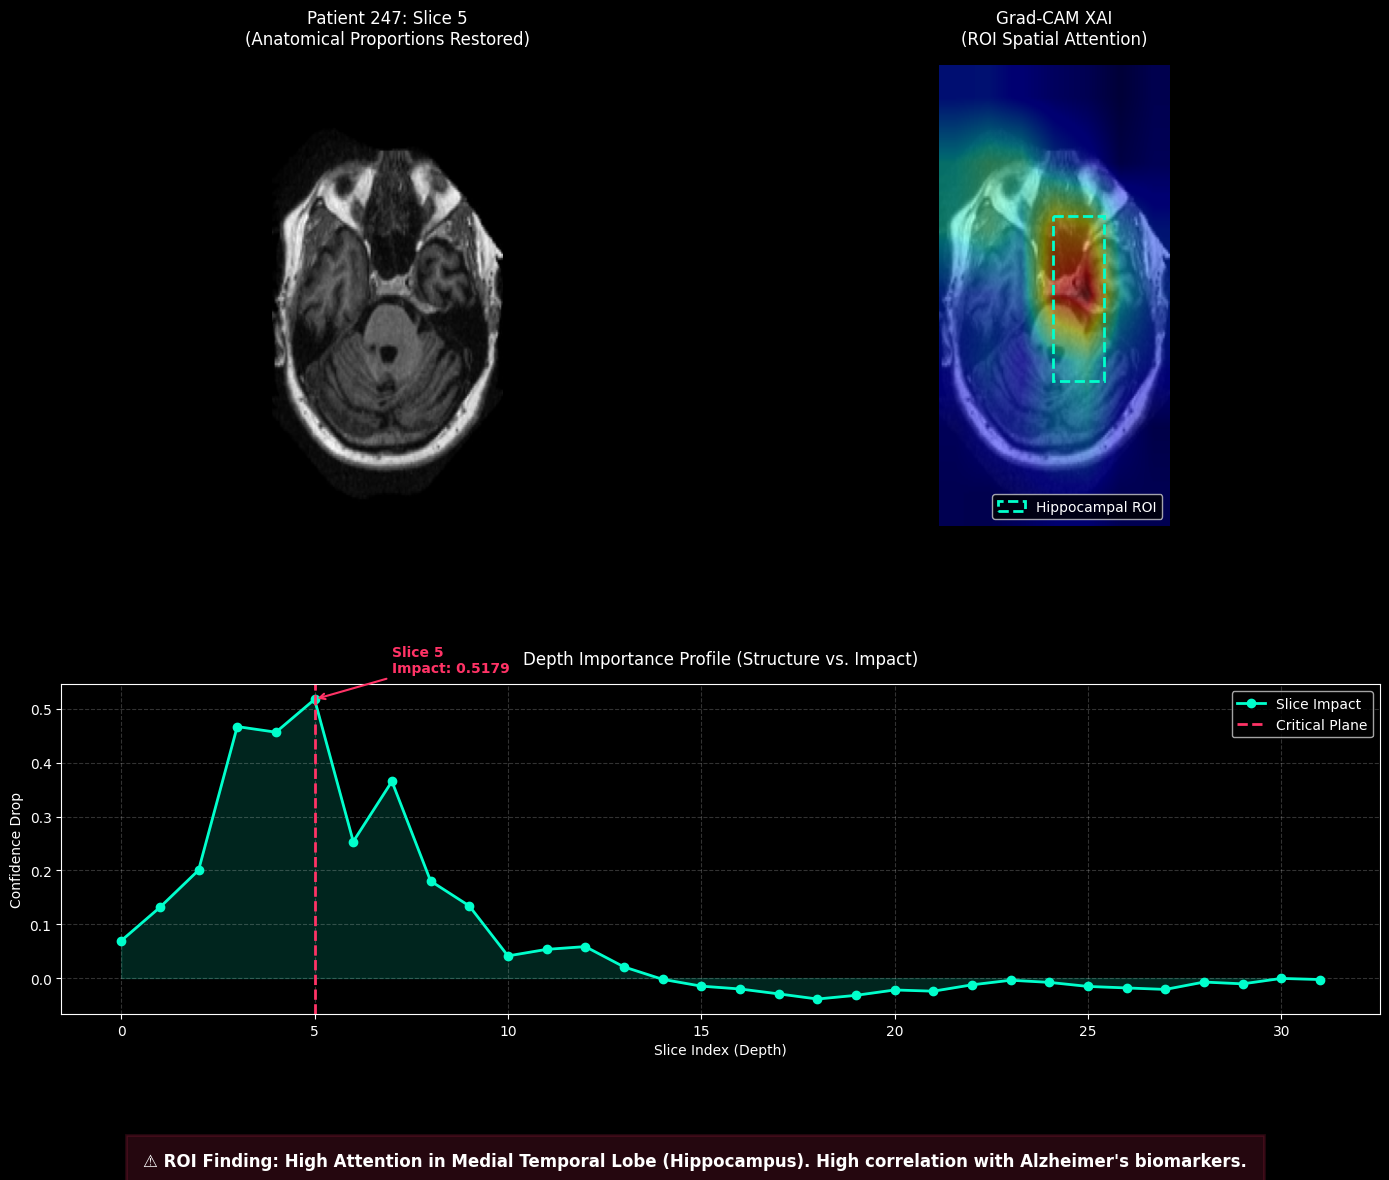

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from PIL import Image

# ============================================================================
# 1. MODEL ARCHITECTURE (Must match your MedicalNet training script)
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches  # Fix for the NameError
import torch.nn.functional as F
import numpy as np

# ============================================================================
# 1. EXACT MODEL ARCHITECTURE (MedicalNet ResNet-18)
# ============================================================================
class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class MedicalNetResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Dropout(0.3), nn.Linear(256, num_classes)
        )

    def _make_layer(self, in_c, out_c, blocks, stride=1):
        layers = [BasicBlock3D(in_c, out_c, stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock3D(out_c, out_c, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = self.avgpool(x).flatten(1)
        return self.fc(x)

# ============================================================================
# 2. FIXED XAI CLASSES
# ============================================================================
class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output): self.activations = output.detach()
    def save_gradient(self, module, grad_in, grad_out): self.gradients = grad_out[0].detach()

    def __call__(self, x, class_idx):
        self.model.zero_grad()
        logits = self.model(x)
        logits[0, class_idx].backward()

        # Calculate weights per channel
        weights = torch.mean(self.gradients, dim=(2, 3, 4), keepdim=True)

        # Compute Weighted Sum (ReLU to keep positive influence)
        # We keep the batch and channel dim temporarily to avoid 4D/5D confusion
        cam = F.relu(torch.sum(weights * self.activations, dim=1, keepdim=True))

        # FIXED: Ensure cam is 5D [Batch, Channel, Depth, Height, Width]
        # At layer4, depth is likely 1, but interpolate requires 5D for 'trilinear'
        cam = F.interpolate(cam, size=x.shape[2:], mode='trilinear', align_corners=False)

        # Squeeze down to the volume dimensions [D, H, W]
        cam = cam.squeeze().cpu().detach().numpy()
        return (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

def run_occlusion(model, x, class_idx):
    model.eval()
    baseline_prob = F.softmax(model(x), dim=1)[0, class_idx].item()
    impacts = []
    for s in range(x.shape[2]):
        occluded = x.clone()
        occluded[:, :, s, :, :] = 0
        with torch.no_grad():
            prob = F.softmax(model(occluded), dim=1)[0, class_idx].item()
            impacts.append(baseline_prob - prob)
    return np.array(impacts)

# ============================================================================
# 3. UTILITIES & PATIENT LOADING
# ============================================================================
def load_patient_volume(data_root, patient_id, target_depth=32, target_size=224):
    all_files = []
    for root, _, files in os.walk(data_root):
        for f in files:
            if f"OAS1_{patient_id:04d}_" in f:
                slice_num = int(re.search(r'_(\d+)\.(jpg|png|jpeg)', f).group(1))
                all_files.append((os.path.join(root, f), slice_num))

    all_files.sort(key=lambda x: x[1])

    # 1. Load and Resize
    slices = [np.array(Image.open(p).convert('L').resize((target_size, target_size))) / 255.0 for p, _ in all_files]
    volume = np.stack(slices)

    # 2. Depth Focus (0.15 to 0.85)
    if len(volume) > target_depth:
        start_idx = int(len(volume) * 0.15)
        end_idx = int(len(volume) * 0.85)
        volume = volume[start_idx:end_idx]

    # 3. EXACT MATCH: Linear Interpolation for Depth
    if len(volume) != target_depth:
        indices = np.linspace(0, len(volume) - 1, target_depth)
        indices_floor = np.floor(indices).astype(int)
        indices_ceil = np.ceil(indices).astype(int)
        weights = indices - indices_floor

        volume_resized = []
        for f, c, w in zip(indices_floor, indices_ceil, weights):
            if f == c:
                volume_resized.append(volume[f])
            else:
                # Blend the slices just like in training
                interpolated = volume[f] * (1 - w) + volume[c] * w
                volume_resized.append(interpolated)
        volume = np.stack(volume_resized, axis=0)

    # 4. Z-Score Normalization
    volume = (volume - volume.mean()) / (volume.std() + 1e-8)

    # Return as (Batch, Channel, Depth, Height, Width)
    return torch.FloatTensor(volume).unsqueeze(0).unsqueeze(0)

# ============================================================================
# 4. ADVANCED XAI VISUALIZATION
# ============================================================================

def get_roi_interpretation(heatmap, pred_idx):
    """Analyzes heatmap activation peaks to identify clinical regions of interest."""
    if pred_idx == 0: return "Analysis: Consistent with normal brain structure."

    # Original ROI coordinates for non-rotated 224x224 image
    roi_y_start, roi_y_end = 110, 160
    roi_x_start, roi_x_end = 70, 150

    # Find peak activation in the original (non-rotated) heatmap
    y_peak, x_peak = np.unravel_index(np.argmax(heatmap), heatmap.shape)

    # Check if peak is within the hippocampal ROI bounds
    is_in_hippocampus = (roi_y_start <= y_peak <= roi_y_end and
                         roi_x_start <= x_peak <= roi_x_end)

    if is_in_hippocampus:
        return "⚠️ ROI Finding: High Attention in Medial Temporal Lobe (Hippocampus). High correlation with Alzheimer's biomarkers."
    else:
        return "AI Insight: Attention focused on broader structural changes (e.g., ventricular enlargement)."

# ============================================================================
# 5. MAIN EXECUTION
# ============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "/kaggle/input/medicalnet-best/pytorch/default/1/medicalnet_resnet18_90acc.pth"
DATA_PATH = "/kaggle/input/imagesoasis/Data"
CLASS_NAMES = ['Non-dementia', 'Dementia']

# Load Model
model = MedicalNetResNet18(num_classes=2).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("✓ Best model loaded successfully.")

# Load Patient 247
input_tensor = load_patient_volume(DATA_PATH, 307).to(device)

# 1. Inference
with torch.no_grad():
    output = model(input_tensor)
    prob = F.softmax(output, dim=1)
    pred_idx = torch.argmax(output, dim=1).item()

print(f"✓ Patient 307 Prediction: {CLASS_NAMES[pred_idx]} ({prob[0, pred_idx].item()*100:.2f}%)")

# 2. XAI Analysis
gcam = GradCAM3D(model, model.layer4)
heatmap_3d = gcam(input_tensor, pred_idx)
occ_scores = run_occlusion(model, input_tensor, pred_idx)
top_slice = np.argmax(occ_scores)

# 1. Configuration & Style
plt.style.use('dark_background')
ROTATED_ASPECT = 2.0

# 2. Process Data: Rotate 90° Left
slice_data = input_tensor[0, 0, top_slice].cpu().numpy()
heatmap_data = heatmap_3d[top_slice]
# Rotate both to maintain alignment
mri_rotated = np.rot90(slice_data, k=1)
heatmap_rotated = np.rot90(heatmap_data, k=1)

# 3. Setup Figure with a 2-Row Grid Layout
fig = plt.figure(figsize=(14, 12))
# Define a grid with 2 rows and 2 columns.
# height_ratios gives the top row (images) a bit more vertical space than the graph.
gs = gridspec.GridSpec(2, 2, height_ratios=[1.4, 1], width_ratios=[1, 1])

# Create axes for the layout
ax1 = fig.add_subplot(gs[0, 0]) # Top-Left: Anatomical View
ax2 = fig.add_subplot(gs[0, 1]) # Top-Right: Grad-CAM XAI
ax3 = fig.add_subplot(gs[1, :]) # Bottom Row (spans both columns): Graph

# --- Row 1, Left: Rotated Anatomical View ---
ax1.imshow(mri_rotated, cmap='gray', aspect=ROTATED_ASPECT)
ax1.set_title(f"Patient 247: Slice {top_slice}\n(Anatomical Proportions Restored)", pad=15, fontsize=12)
ax1.axis('off')

# --- Row 1, Right: Rotated Grad-CAM with Corrected ROI Box ---
ax2.imshow(mri_rotated, cmap='gray', aspect=ROTATED_ASPECT)
ax2.imshow(heatmap_rotated, cmap='jet', alpha=0.45, aspect=ROTATED_ASPECT)

# Corrected ROI coordinates for 90° left rotation.
# Original box (x=70, y=110, w=80, h=50) becomes (x=110, y=73, w=50, h=80) after rotation.
roi_box_rot = patches.Rectangle((110, 73), 50, 80, linewidth=2, edgecolor='#00ffcc',
                                facecolor='none', linestyle='--', label='Hippocampal ROI')
ax2.add_patch(roi_box_rot)
ax2.set_title("Grad-CAM XAI\n(ROI Spatial Attention)", pad=15, fontsize=12)
ax2.axis('off')
ax2.legend(handles=[roi_box_rot], loc='lower right', fontsize=10)

# --- Row 2, Full Width: Depth Importance Profile ---
top_idx = np.argmax(occ_scores)
max_impact = occ_scores[top_idx]

ax3.plot(occ_scores, color='#00ffcc', marker='o', markersize=6, linewidth=2, label='Slice Impact')
ax3.fill_between(range(len(occ_scores)), occ_scores, color='#00ffcc', alpha=0.15)
ax3.axvline(top_idx, color='#ff3366', linestyle='--', linewidth=2, label='Critical Plane')

# Add a clear annotation for the peak value
ax3.annotate(f'Slice {top_idx}\nImpact: {max_impact:.4f}',
             xy=(top_idx, max_impact), xytext=(top_idx + 2, max_impact + 0.05),
             color='#ff3366', fontweight='bold', fontsize=10,
             arrowprops=dict(arrowstyle='->', color='#ff3366', lw=1.5))

ax3.set_title("Depth Importance Profile (Structure vs. Impact)", pad=15, fontsize=12)
ax3.set_xlabel("Slice Index (Depth)", fontsize=10)
ax3.set_ylabel("Confidence Drop", fontsize=10)
ax3.grid(True, alpha=0.2, linestyle='--')
ax3.legend(loc='upper right', fontsize=10)

# 4. Final Layout & Clinical Text
# Get interpretation based on original (non-rotated) data for accuracy
roi_text = get_roi_interpretation(heatmap_data, pred_idx)

# Adjust layout space
plt.tight_layout()
# Add extra space at the bottom for the text box and between rows
plt.subplots_adjust(bottom=0.15, hspace=0.4)

# Add the clinical interpretation text box at the bottom
plt.figtext(0.5, 0.02, roi_text, wrap=True, horizontalalignment='center',
            verticalalignment='bottom', fontsize=12, fontweight='bold', color='white',
            bbox={'facecolor': '#ff3366', 'alpha': 0.15, 'pad': 12, 'edgecolor': '#ff3366', 'linewidth': 2})

plt.show()
# Reset style
plt.style.use('default')

## ROC-AUC

Model loaded successfully!


Computing probabilities: 100%|██████████| 18/18 [00:01<00:00,  9.20it/s]


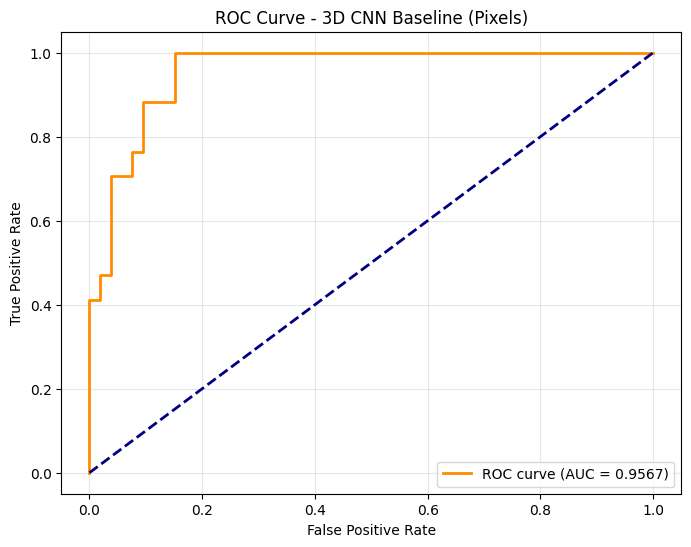

In [ ]:
import os
import json
import numpy as np
from collections import defaultdict
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# =========================
# CONFIG
# =========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 4
MODEL_PATH = '/kaggle/input/3d-cnn-baseline/pytorch/default/1/3d_cnn_baseline_pixels_model.pth'
TARGET_SIZE = 256
TARGET_DEPTH = 32
REMOVE_DARK_SLICES = 20

# =========================
# UTILITY FUNCTIONS
# =========================
def load_slice_as_pixel(img_path, target_size=TARGET_SIZE):
    img = Image.open(img_path).convert('L')
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
    return np.array(img, dtype=np.float32) / 255.0

def load_pixel_volume_from_patient(patient_data, target_size=TARGET_SIZE):
    slices = patient_data['slices']
    pixel_slices = [load_slice_as_pixel(s['path'], target_size) for s in slices]
    return np.stack(pixel_slices, axis=0)

def remove_dark_slices(pixel_volume, n_slices=REMOVE_DARK_SLICES):
    if pixel_volume.shape[0] <= n_slices:
        return pixel_volume
    slice_intensity = [(i, np.mean(pixel_volume[i])) for i in range(pixel_volume.shape[0])]
    slice_intensity.sort(key=lambda x: x[1])
    remove_idx = {idx for idx, _ in slice_intensity[:n_slices]}
    keep_idx = [i for i in range(pixel_volume.shape[0]) if i not in remove_idx]
    return pixel_volume[keep_idx]

def normalize_pixel_volume(pixel_volume):
    mean, std = np.mean(pixel_volume), np.std(pixel_volume)
    return ((pixel_volume - mean) / (std + 1e-8)).astype(np.float32) if std > 0 else pixel_volume

def resize_pixel_volume(pixel_volume, target_depth=TARGET_DEPTH):
    current_depth = pixel_volume.shape[0]
    if current_depth == target_depth:
        return pixel_volume
    zoom_factor = target_depth / current_depth
    return zoom(pixel_volume, (zoom_factor, 1.0, 1.0), order=1).astype(np.float32)

# =========================
# DATASET CLASS
# =========================
class PixelVolumeDataset(Dataset):
    def __init__(self, pixel_volumes_dict):
        self.patient_ids = list(pixel_volumes_dict.keys())
        self.pixels = [pixel_volumes_dict[pid]['pixels'] for pid in self.patient_ids]
        self.labels = [pixel_volumes_dict[pid]['label'] for pid in self.patient_ids]

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        pixels = torch.FloatTensor(self.pixels[idx]).unsqueeze(0)  # (1, depth, H, W)
        label = torch.LongTensor([self.labels[idx]])[0]
        return pixels, label

# =========================
# MODEL DEFINITION
# =========================
class ResNet18_3D_Pixels(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv3d_block1 = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3)),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 3, 3), stride=(2, 2, 2), padding=(0, 1, 1))
        )
        self.conv3d_block2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2)
        )
        self.conv3d_block3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2)
        )
        self.conv3d_block4 = nn.Sequential(
            nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1, 1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv3d_block1(x)
        x = self.conv3d_block2(x)
        x = self.conv3d_block3(x)
        x = self.conv3d_block4(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# =========================
# LOAD DATA
# =========================
# Load patient split and processed_pixels
PATIENT_SPLIT_JSON = '/kaggle/input/patient-split-1/patient_split.json'
DATA_ROOT = '/kaggle/input/imagesoasis/Data'
CLASS_MAPPING = {
    'Non Demented': 0,
    'Very mild Dementia': 1,
    'Mild Dementia': 1,
    'Moderate Dementia': 1
}

def extract_patient_id(filename):
    import re
    match = re.search(r'OAS1_(\d+)_', filename)
    return int(match.group(1)) if match else None

def extract_slice_number(filename):
    import re
    match = re.search(r'_(\d+)\.(jpg|jpeg|png)$', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None

def load_patient_split(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def load_slices_by_patient(data_root, class_mapping):
    patient_slices = defaultdict(lambda: {'slices': [], 'label': None, 'class': None})
    for class_name, class_label in class_mapping.items():
        class_dir = os.path.join(data_root, class_name)
        if not os.path.exists(class_dir):
            continue
        for filename in os.listdir(class_dir):
            if not filename.endswith(('.jpg', '.jpeg', '.png')):
                continue
            patient_id = extract_patient_id(filename)
            slice_num = extract_slice_number(filename)
            if patient_id is None or slice_num is None:
                continue
            patient_slices[patient_id]['slices'].append({
                'path': os.path.join(class_dir, filename),
                'slice_num': slice_num
            })
            patient_slices[patient_id]['label'] = class_label
            patient_slices[patient_id]['class'] = class_name
    for pid in patient_slices:
        patient_slices[pid]['slices'].sort(key=lambda x: x['slice_num'])
    return dict(patient_slices)

split_data = load_patient_split(PATIENT_SPLIT_JSON)
patient_slices = load_slices_by_patient(DATA_ROOT, CLASS_MAPPING)

# Preprocess test set
test_pixels = {}
for pid in split_data['test_patients']:
    if pid not in patient_slices:
        continue
    pixels = load_pixel_volume_from_patient(patient_slices[pid], target_size=TARGET_SIZE)
    pixels = remove_dark_slices(pixels, n_slices=REMOVE_DARK_SLICES)
    pixels = normalize_pixel_volume(pixels)
    pixels = resize_pixel_volume(pixels, target_depth=TARGET_DEPTH)
    test_pixels[pid] = {'pixels': pixels, 'label': patient_slices[pid]['label']}

test_dataset = PixelVolumeDataset(test_pixels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# =========================
# LOAD MODEL
# =========================
model = ResNet18_3D_Pixels(num_classes=2).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Model loaded successfully!")

# =========================
# COMPUTE PROBABILITIES
# =========================
softmax = nn.Softmax(dim=1)
all_labels, all_probs = [], []

with torch.no_grad():
    for pixels, labels in tqdm(test_loader, desc="Computing probabilities"):
        pixels = pixels.to(DEVICE)
        outputs = model(pixels)
        probs = softmax(outputs)[:, 1]  # Probabilities for class 1 (Dementia)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# =========================
# ROC-AUC
# =========================
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - 3D CNN Baseline (Pixels)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Initializing...


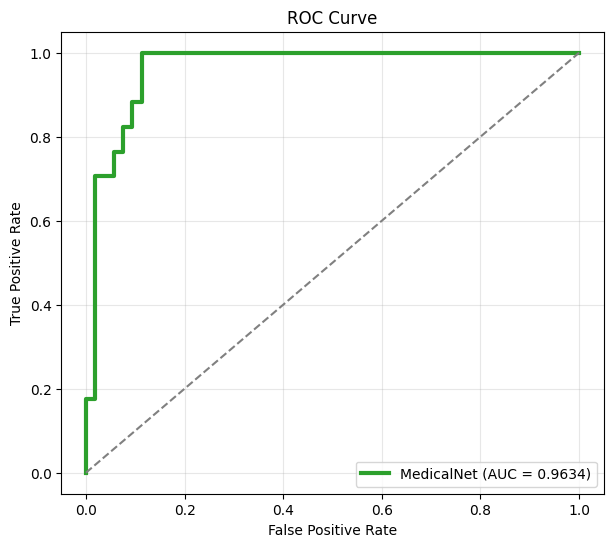

Final AUC: 0.9634


In [ ]:
import os
import re
import json
import torch
import torch.nn as nn
import numpy as np
from collections import defaultdict
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ============================================================================
# 1. CONFIGURATION & PATHS
# ============================================================================
TEST_WEIGHTS = '/kaggle/input/medicalnet-best/pytorch/default/1/medicalnet_resnet18_90acc.pth'
JSON_PATH = '/kaggle/input/patient-split-1/patient_split.json'
DATA_DIR = '/kaggle/input/imagesoasis/Data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CLASS_MAPPING = {
    'Non Demented': 0,
    'Very mild Dementia': 1,
    'Mild Dementia': 1,
    'Moderate Dementia': 1
}

# ============================================================================
# 2. MODEL ARCHITECTURE (Required to load .pth)
# ============================================================================
class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity
        return self.relu(out)

class MedicalNetResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes))
    def _make_layer(self, in_c, out_c, blocks, stride=1):
        layers = [BasicBlock3D(in_c, out_c, stride)]
        for _ in range(1, blocks): layers.append(BasicBlock3D(out_c, out_c, 1))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        return self.fc(self.avgpool(x).flatten(1))

# ============================================================================
# 3. UTILITIES & DATA LOADING
# ============================================================================
def load_and_process_volume_fast(slice_paths, target_size=224, target_depth=32, remove_dark=20):
    slices = []
    for p in slice_paths:
        img = Image.open(p).convert('L').resize((target_size, target_size), Image.Resampling.BILINEAR)
        slices.append(np.array(img, dtype=np.float32) / 255.0)
    volume = np.stack(slices, axis=0)
    if len(volume) > target_depth:
        volume = volume[int(len(volume)*0.15):int(len(volume)*0.85)]
    indices = np.linspace(0, len(volume) - 1, target_depth).astype(int)
    volume = np.expand_dims(volume[indices], axis=0)
    std = volume.std()
    return (volume - volume.mean()) / (std + 1e-8) if std > 0 else volume

class MedicalNetDataset(Dataset):
    def __init__(self, meta, target_size=224, target_depth=32, remove_dark=20):
        self.pids = list(meta.keys()); self.meta = meta
    def __len__(self): return len(self.pids)
    def __getitem__(self, idx):
        data = self.meta[self.pids[idx]]
        vol = load_and_process_volume_fast([s['path'] for s in data['slices']])
        return torch.from_numpy(vol), torch.tensor(data['label'], dtype=torch.long)

def load_patient_split(path):
    with open(path, 'r') as f: return json.load(f)

def extract_patient_id(f):
    m = re.search(r'OAS1_(\d+)_', f)
    return int(m.group(1)) if m else None

def extract_slice_number(f):
    m = re.search(r'_(\d+)\.(jpg|jpeg|png)$', f, re.IGNORECASE)
    return int(m.group(1)) if m else None

def load_slices_by_patient(root, mapping):
    pts = defaultdict(lambda: {'slices': [], 'label': None})
    for c_name, c_lab in mapping.items():
        c_dir = os.path.join(root, c_name)
        if not os.path.exists(c_dir): continue
        for f in os.listdir(c_dir):
            pid, s_num = extract_patient_id(f), extract_slice_number(f)
            if pid is not None: pts[pid]['slices'].append({'path': os.path.join(c_dir, f), 'slice_num': s_num}); pts[pid]['label'] = c_lab
    for p in pts: pts[p]['slices'].sort(key=lambda x: x['slice_num'])
    return dict(pts)

def split_by_patient_json(pts, split):
    test_p = set(split['test_patients'])
    return {pid: pts[pid] for pid in test_p if pid in pts}

# ============================================================================
# 4. EXECUTION
# ============================================================================
print("Initializing...")
pts = load_slices_by_patient(DATA_DIR, CLASS_MAPPING)
split = load_patient_split(JSON_PATH)
test_meta = split_by_patient_json(pts, split)
test_loader = DataLoader(MedicalNetDataset(test_meta), batch_size=4, shuffle=False)

model = MedicalNetResNet18().to(device)
model.load_state_dict(torch.load(TEST_WEIGHTS, map_location=device))
model.eval()

all_probs, all_labels = [], []
with torch.no_grad():
    for px, lb in test_loader:
        out = model(px.to(device))
        all_probs.extend(torch.softmax(out, dim=1)[:, 1].cpu().numpy())
        all_labels.extend(lb.numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='#2ca02c', lw=3, label=f'MedicalNet (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.legend(); plt.grid(alpha=0.3); plt.show()
print(f"Final AUC: {roc_auc:.4f}")